## Семинар 2 "Распознавание рукописных цифр"

ФИО: Васильев Семён Михайлович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from tqdm import tqdm
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
import sys
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

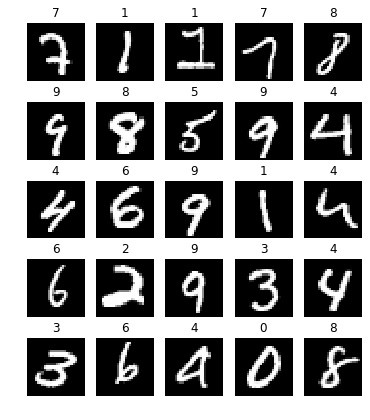

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
def train(network, loss_func, epochs, lr, train_loader, test_loader, \
          plot=True, verbose=True):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    for epoch in range(epochs):
        losses = []
        accuracies = []
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
            predictions = network.forward(X)
            loss_batch = loss_func.forward(predictions, y)
            losses.append(loss_batch)
            network.backward(loss_func.backward())
            network.step(lr)
            accuracies.append((np.argmax(predictions, 1)==y).mean())
        train_loss_epochs.append(np.mean(losses))
        train_accuracy_epochs.append(np.mean(accuracies))
        losses = []
        accuracies = []
        for X, y in test_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
            predictions = network.forward(X)
            loss_batch = loss_func.forward(predictions, y)
            losses.append(loss_batch)
            accuracies.append((np.argmax(predictions, 1)==y).mean())
        test_loss_epochs.append(np.mean(losses))
        test_accuracy_epochs.append(np.mean(accuracies))
        clear_output(True)
        if verbose:
            sys.stdout.write(
                '\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]
                )
            )
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [6]:
network = NeuralNetwork([Linear(784, 100), Sigmoid(), 
           Linear(100, 100), Sigmoid(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.307/0.302	Accuracy: 0.919/0.919

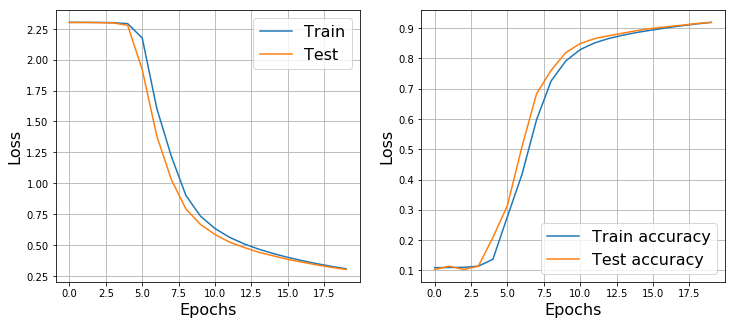

In [7]:
train_loss_s, test_loss_s, \
train_acc_s, test_acc_s = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        return np.maximum(X, 0)
    
    def backward(self, dLdy):
        return (self.X > 0).astype(float) * dLdy
    
    def step(self , lr):
        pass

In [9]:
class ELU:
    def __init__(self, a=1):
        self.a = a
    
    def forward(self, X):
        self.X = X
        return (X >= 0) * X + (X < 0) * self.a * (np.exp(X) - 1)
    
    def backward(self, dLdy):
#         print(dLdy.shape)
#         print(((self.X > 0) + (self.X <= 0) * self.a * np.exp(self.X)).shape)
        return dLdy * ((self.X > 0) + (self.X <= 0) * self.a * np.exp(self.X))
    
    def step(self, lr):
        pass

In [10]:
network = NeuralNetwork([Linear(784, 100), ReLU(), 
           Linear(100, 100), ReLU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.037/0.081	Accuracy: 0.990/0.975

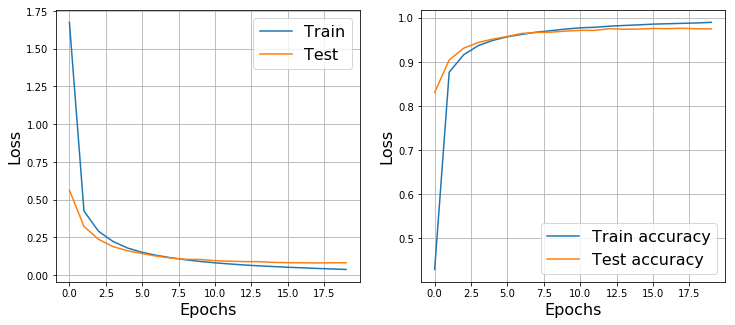

In [11]:
train_loss_r, test_loss_r, \
train_acc_r, test_acc_r = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

In [12]:
network = NeuralNetwork([Linear(784, 100), ELU(), 
           Linear(100, 100), ELU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.047/0.083	Accuracy: 0.987/0.974

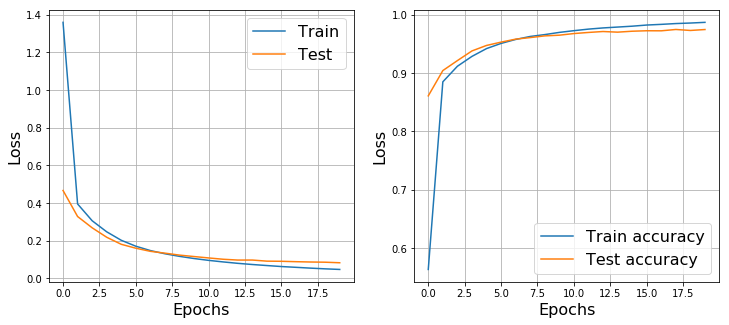

In [13]:
train_loss_e, test_loss_e, \
train_acc_e, test_acc_e = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

### HW1 (1 балл): Реализовать Tanh

In [14]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        self.X = X
        self.y = np.tanh(X)
        return self.y
    
    def backward(self, dLdy):
        return dLdy * (1 - self.y ** 2)
    
    def step(self, lr):
        pass

In [15]:
network = NeuralNetwork([Linear(784, 100), Tanh(), 
           Linear(100, 100), Tanh(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.031/0.082	Accuracy: 0.993/0.975

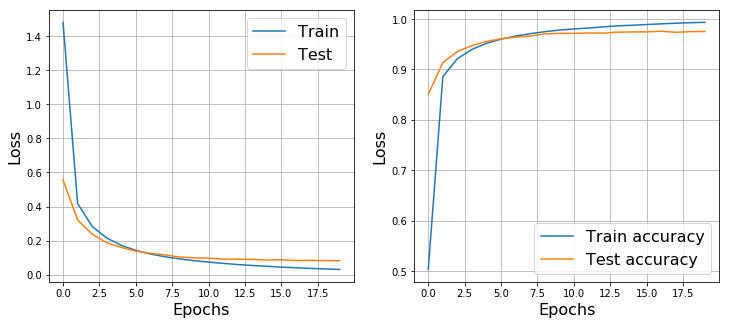

In [16]:
train_loss_t, test_loss_t, \
train_acc_t, test_acc_t = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

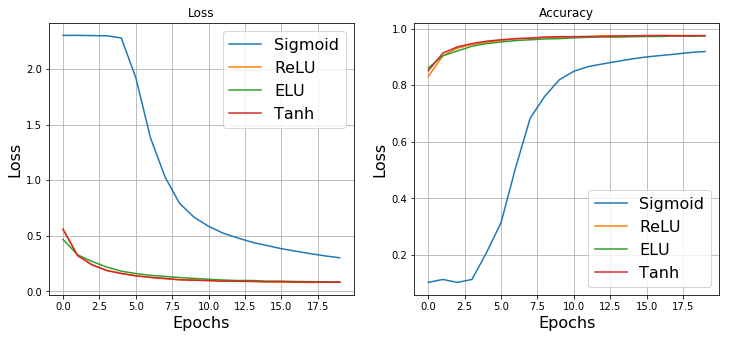

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(test_loss_s, label='Sigmoid')
plt.plot(test_loss_r, label='ReLU')
plt.plot(test_loss_e, label='ELU')
plt.plot(test_loss_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(test_acc_s, label='Sigmoid')
plt.plot(test_acc_r, label='ReLU')
plt.plot(test_acc_e, label='ELU')
plt.plot(test_acc_t, label='Tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 3: Анализ ошибок

In [18]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

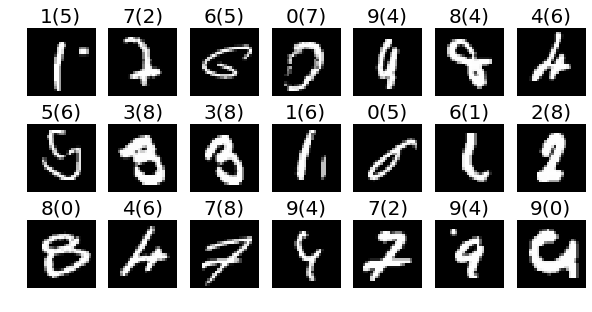

In [19]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [20]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [21]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

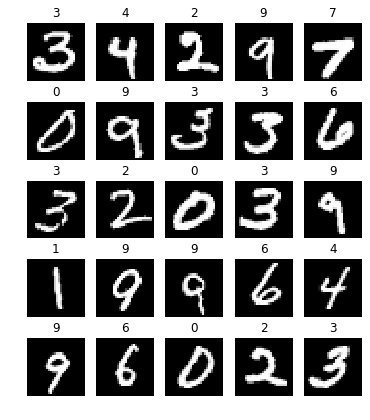

In [22]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [23]:
network = NeuralNetwork([Linear(784, 100), ReLU(), 
           Linear(100, 100), ReLU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.038/0.083	Accuracy: 0.990/0.975

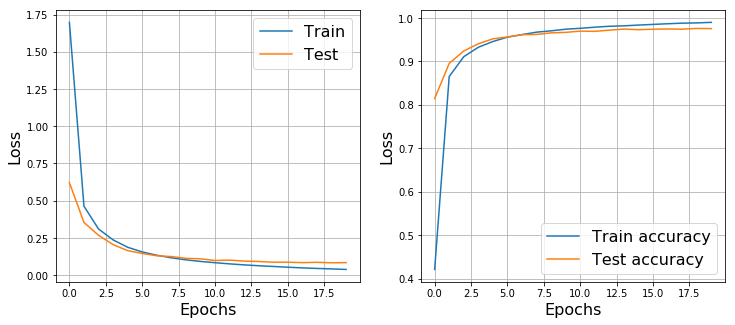

In [24]:
train_loss_norm, test_loss_norm, \
train_acc_norm, test_acc_norm = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

Повороты

In [25]:
transform = transforms.Compose([
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [26]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

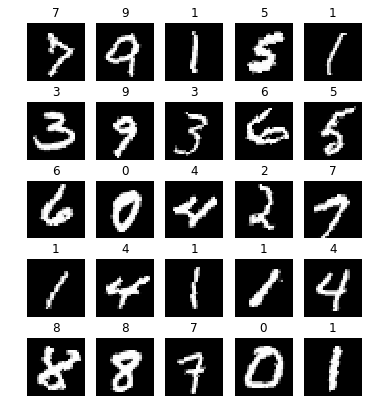

In [27]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [28]:
network = NeuralNetwork([Linear(784, 100), ReLU(), 
           Linear(100, 100), ReLU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.075/0.081	Accuracy: 0.977/0.975

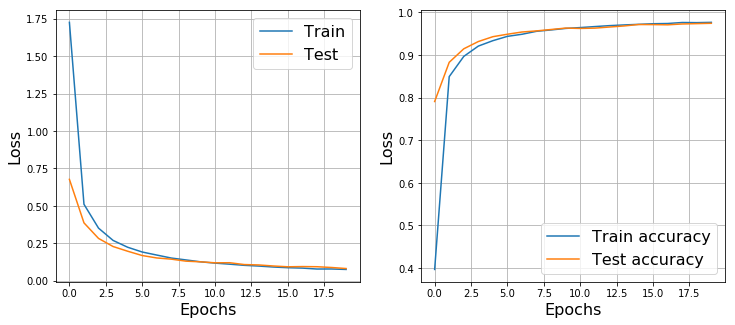

In [29]:
train_loss_rot, test_loss_rot, \
train_acc_rot, test_acc_rot = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

Сдвиги

In [30]:
transform = transforms.Compose([
                       transforms.RandomAffine(0, (0.2, 0.2)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [31]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

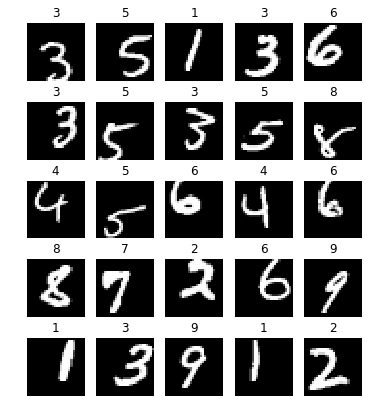

In [32]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [33]:
network = NeuralNetwork([Linear(784, 100), ReLU(), 
           Linear(100, 100), ReLU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.200/0.174	Accuracy: 0.939/0.947

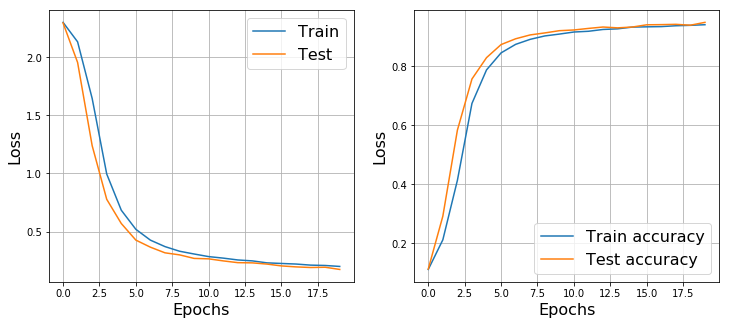

In [34]:
train_loss_trans, test_loss_trans, \
train_acc_trans, test_acc_trans = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

Шум

In [35]:
from torch import rand_like

In [36]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x : x + rand_like(x) / 5),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [37]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

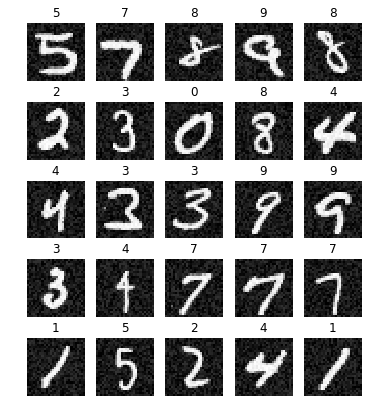

In [38]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [39]:
network = NeuralNetwork([Linear(784, 100), ReLU(), 
           Linear(100, 100), ReLU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.046/0.084	Accuracy: 0.986/0.975

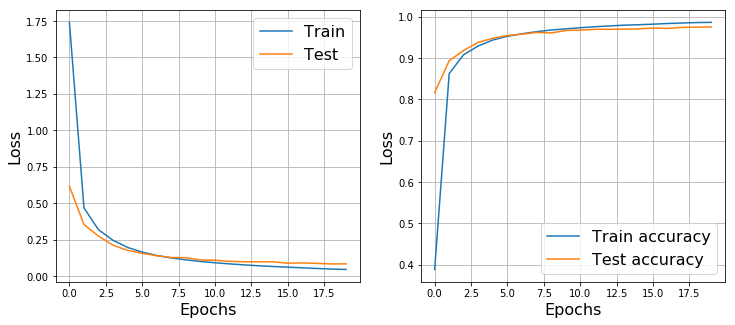

In [40]:
train_loss_noise, test_loss_noise, \
train_acc_noise, test_acc_noise = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

In [41]:
transform = transforms.Compose([
                       transforms.RandomRotation(15),
                       transforms.RandomAffine(0, (0.2, 0.2)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x : x + rand_like(x) / 5),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [42]:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

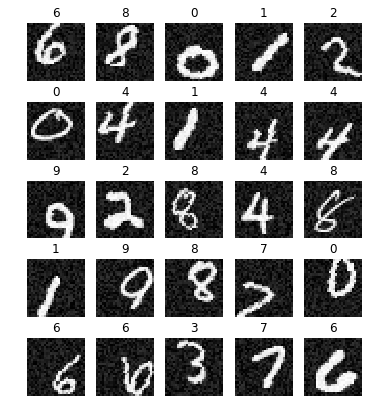

In [43]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [44]:
network = NeuralNetwork([Linear(784, 100), ReLU(), 
           Linear(100, 100), ReLU(), Linear(100, 10)])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.263/0.253	Accuracy: 0.920/0.920

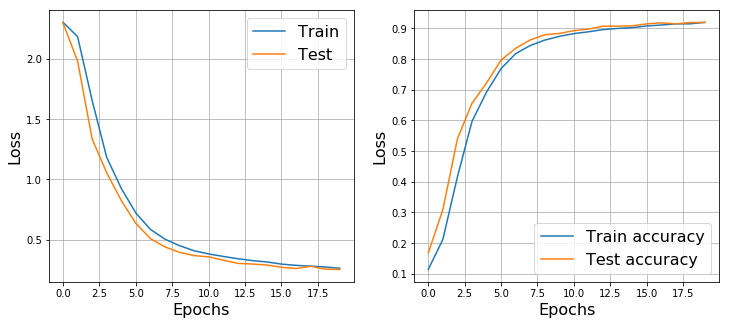

In [45]:
train_loss_all, test_loss_all, \
train_acc_all, test_acc_all = train(network, loss, 20, 0.01, 
                           train_loader, test_loader)

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

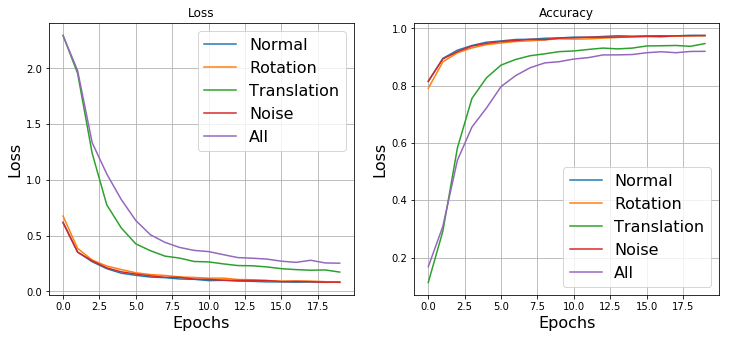

In [46]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(test_loss_norm, label='Normal')
plt.plot(test_loss_rot, label='Rotation')
plt.plot(test_loss_trans, label='Translation')
plt.plot(test_loss_noise, label='Noise')
plt.plot(test_loss_all, label='All')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(test_acc_norm, label='Normal')
plt.plot(test_acc_rot, label='Rotation')
plt.plot(test_acc_trans, label='Translation')
plt.plot(test_acc_noise, label='Noise')
plt.plot(test_acc_all, label='All')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

ReLU, ELU и Tanh показывают примерно одинаковую скорость сходимости, большую чем сигмоида.
При 20 эпохах обучения аугментация не ускоряет сходимость, а сдвиги и комбинация преобразований замедляют.